## Importing the Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

In [3]:
#Read dataset
df = pd.read_csv('./data/CICIDS2017_sample.csv') 
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,4,2,0,37,0,31,6,18.500000,17.677670,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,142377,46,62,1325,105855,570,0,28.804348,111.407285,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,118873,23,28,1169,45025,570,0,50.826087,156.137367,2896,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,143577,43,55,1301,107289,570,0,30.255814,115.178969,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,143745,49,59,1331,110185,570,0,27.163265,108.067176,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56656,234,2,2,64,232,32,32,32.000000,0.000000,116,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56657,133288,2,2,94,482,47,47,47.000000,0.000000,241,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56658,11507694,5,4,450,3525,450,0,90.000000,201.246118,3525,...,32,893.0,0.0,893,893,6503640.0,0.0,6503640,6503640,DoS
56659,11507707,8,6,416,11632,416,0,52.000000,147.078211,5792,...,32,897.0,0.0,897,897,6503122.0,0.0,6503122,6503122,DoS


In [4]:
df.Label.value_counts()

Label
BENIGN          22731
DoS             19035
PortScan         7946
BruteForce       2767
WebAttack        2180
Bot              1966
Infiltration       36
Name: count, dtype: int64

### Preprocessing (normalization and padding values)


In [5]:
# Z-score normalization
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

### Data sampling


In [6]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])

In [7]:
df.Label.value_counts()

Label
0    22731
3    19035
5     7946
2     2767
6     2180
1     1966
4       36
Name: count, dtype: int64

Here the minority class instances are of the indexes 6,1,4 (the last 3 instances)

In [ ]:
# retain the minority class instances and sample the majority class instances
df_minor = df[(df['Label']==6)|(df['Label']==1)|(df['Label']==4)]
df_major = df.drop(df_minor.index)

In [ ]:
X = df_major.drop(['Label'],axis=1) 
y = df_major.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [ ]:
# use k-means to cluster the data samples and select a proportion of data from each cluster
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0).fit(X)

klabel=kmeans.labels_
df_major['klabel']=klabel

df_major['klabel'].value_counts()

The purpose of this code is to perform K-means clustering on a dataset (X) and then analyze the distribution of data points across the clusters. This information can be used for various purposes such as:

Understanding the natural groupings or patterns in the data.
Segmenting the data for further analysis or targeted actions.
Selecting representative samples from each cluster for downstream ta

## Eg
 Assuming df_major is a DataFrame containing the data and X is the feature matrix, the output of df_major['klabel'].value_counts() will be a Series where the index represents the cluster labels and the values represent the number of data points in each cluster.sks.

This output indicates that there are 1500 data points in cluster 0, 1200 data points in cluster 1, 900 data points in cluster 2, and so on.

In [ ]:
cols = list(df_major)
cols.insert(78, cols.pop(cols.index('Label')))
df_major = df_major.loc[:, cols]

In [ ]:
df_major

In [ ]:
def typicalSampling(group):
    name = group.name
    frac = 0.008
    return group.sample(frac=frac)

result = df_major.groupby(
    'klabel', group_keys=False
).apply(typicalSampling)

The purpose of this code is to sample a specified fraction of rows from each cluster in the DataFrame. This is useful for creating a smaller, more manageable dataset that still represents the distribution of the original data across different clusters.

In [ ]:
result['Label'].value_counts()

In [ ]:
result = result.drop(['klabel'],axis=1)


In [ ]:
result = pd.concat([result, df_minor], ignore_index=True)

In [ ]:
result.to_csv('./data/CICIDS2017_sample_km.csv',index=0)

### split train set and test set using the sampled set

In [ ]:
# Read the sampled dataset
df_sampled=pd.read_csv('./data/CICIDS2017_sample_km.csv')

In [15]:
X = df.drop(['Label'], axis=1).values
y = df['Label'].values

# Flatten y to ensure it is a 1-dimensional array
y = np.ravel(y)

# Check the shapes to confirm
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")


Shape of X: (56661, 77)
Shape of y: (56661,)


In [18]:
unique_values = np.unique(y)
print("Unique values in y:", unique_values)

Unique values in y: [0 1 2 3 4 5 6]


In [20]:
if not np.issubdtype(y.dtype, np.integer):
    y = y.astype(int)

unique_values = np.unique(y)
print("Unique values in y after conversion:", unique_values)


Unique values in y after conversion: [0 1 2 3 4 5 6]


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

## Feature Engineering

### Feature selection by Information Gain

In [22]:
print(y_train.dtype)


int32


In [24]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

#### Interpretation
Higher Scores: Features with higher mutual information scores are more informative about the target variable.
Lower Scores: Features with lower scores provide less information about the targetity.

#### Use Case in Feature Selection
Mutual information scores can be used to select a subset of features that are most relevant to the target variable. This can improve model performance by reducing overfitting and computational complexity.

In [26]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [27]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [28]:
X_fs = df[fs].values
##  X_fs_1 is to be checked without using the FCBF Filter
X_fs_1=df[fs].values

In [29]:
X_fs.shape

(56661, 45)

### Feature selection by Fast Correlation Based Filter (FCBF)

This is a Moudule imported from GitHub repo: https://github.com/SantiagoEG/FCBF_module, which is a custom Module

Certain features are redundant because they contain very similar information. FCBF can remove redundant features by calculating the correlation between each pair of features.

In [30]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [31]:
X_fss = fcbf.fit_transform(X_fs,y)

In [32]:
X_fss.shape

(56661, 20)

## Re-split train & test sets after feature selection


This is done inclusing the FCBF Filtering

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [40]:
X_train.shape

(45328, 20)

In [41]:
from imblearn.over_sampling import SMOTE

# Define SMOTE with the correct sampling strategy
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Fit and resample
X_train, y_train = smote.fit_resample(X_train, y_train)

In [42]:
pd.Series(y_train).value_counts()

5    18184
3    18184
2    18184
0    18184
6    18184
1    18184
4    18184
Name: count, dtype: int64

Accuracy of XGBoost: 0.9857936998147004
Precision of XGBoost: 0.9900390367607242
Recall of XGBoost: 0.9857936998147004
F1-score of XGBoost: 0.9876092262679496
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      4547
           1       0.94      0.99      0.97       393
           2       0.96      1.00      0.98       554
           3       1.00      1.00      1.00      3807
           4       0.09      0.71      0.16         7
           5       0.99      1.00      1.00      1589
           6       0.94      0.99      0.96       436

    accuracy                           0.99     11333
   macro avg       0.85      0.95      0.86     11333
weighted avg       0.99      0.99      0.99     11333



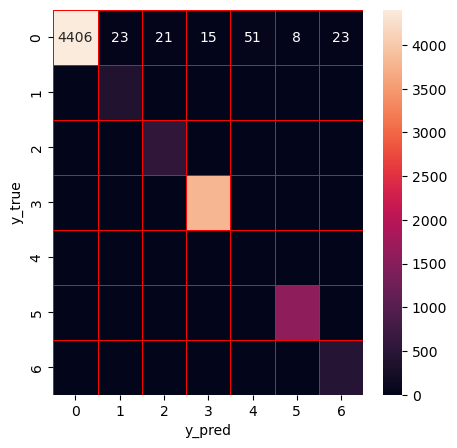

In [43]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [45]:
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [00:35<00:00,  1.75s/trial, best loss: -0.9947057266390188]
XGBoost: Hyperopt estimated optimum {'learning_rate': 0.22794844693636784, 'max_depth': 93.0, 'n_estimators': 80.0}


Accuracy of XGBoost: 0.9947057266390188
Precision of XGBoost: 0.995315186571265
Recall of XGBoost: 0.9947057266390188
F1-score of XGBoost: 0.9949396575010943
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.99      0.99      0.99       393
           2       0.99      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.31      0.71      0.43         7
           5       1.00      1.00      1.00      1589
           6       0.96      1.00      0.98       436

    accuracy                           0.99     11333
   macro avg       0.89      0.96      0.91     11333
weighted avg       1.00      0.99      0.99     11333



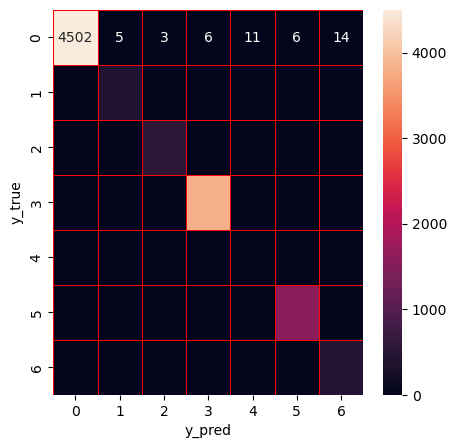

In [46]:
xg = xgb.XGBClassifier(learning_rate= 0.22794844693636784, n_estimators = 80, max_depth = 93)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [47]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

### Random Forest

Accuracy of RF: 0.9946174887496692
Precision of RF: 0.995080224855607
Recall of RF: 0.9946174887496692
F1-score of RF: 0.9947907822365064
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.99      0.99      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.36      0.71      0.48         7
           5       0.99      1.00      1.00      1589
           6       0.96      1.00      0.98       436

    accuracy                           0.99     11333
   macro avg       0.90      0.95      0.92     11333
weighted avg       1.00      0.99      0.99     11333



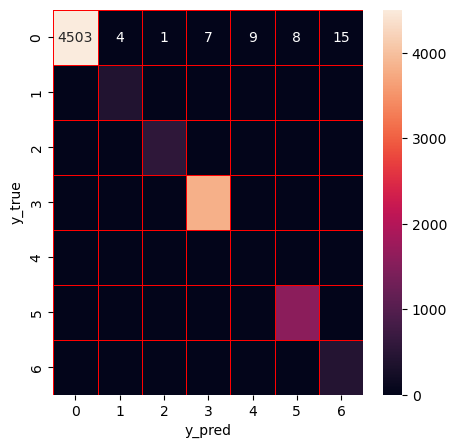

In [49]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [50]:
# Hyperparameter optimization of random forest
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [11:04<00:00, 33.20s/trial, best loss: -0.9939998235242213]
Random Forest: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 23.0, 'max_features': 5.0, 'min_samples_leaf': 5.0, 'min_samples_split': 8.0, 'n_estimators': 150.0}


Accuracy of RF: 0.9939998235242213
Precision of RF: 0.9945156401698576
Recall of RF: 0.9939998235242213
F1-score of RF: 0.9942024947101131
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.98      0.99      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.29      0.57      0.38         7
           5       0.99      1.00      1.00      1589
           6       0.96      1.00      0.98       436

    accuracy                           0.99     11333
   macro avg       0.89      0.93      0.90     11333
weighted avg       0.99      0.99      0.99     11333



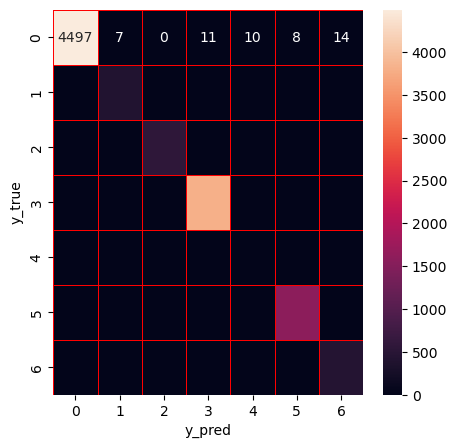

In [51]:
rf_hpo = RandomForestClassifier(n_estimators = 150, min_samples_leaf = 5, max_depth = 23, min_samples_split = 8, max_features = 5, criterion = 'entropy')
rf_hpo.fit(X_train,y_train)
rf_score=rf_hpo.score(X_test,y_test)
y_predict=rf_hpo.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [56]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

### Decision Tree

Accuracy of DT: 0.9932056825200741
Precision of DT: 0.9940084562251895
Recall of DT: 0.9932056825200741
F1-score of DT: 0.9935160393331087
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.98      0.99      0.98       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.28      0.71      0.40         7
           5       1.00      1.00      1.00      1589
           6       0.95      0.99      0.97       436

    accuracy                           0.99     11333
   macro avg       0.88      0.95      0.91     11333
weighted avg       0.99      0.99      0.99     11333



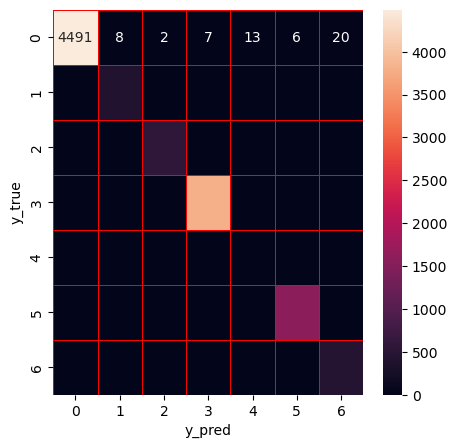

In [52]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [53]:
# Hyperparameter optimization of decision tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = DecisionTreeClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)
print("Decision tree: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 50/50 [00:21<00:00,  2.32trial/s, best loss: -0.9934703961881232]
Decision tree: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 49.0, 'max_features': 11.0, 'min_samples_leaf': 2.0, 'min_samples_split': 3.0}


Accuracy of DT: 0.992676255183976
Precision of DT: 0.9932166203989059
Recall of DT: 0.992676255183976
F1-score of DT: 0.992888934820264
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.98      0.99      0.98       393
           2       0.99      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.29      0.57      0.38         7
           5       0.99      1.00      1.00      1589
           6       0.94      0.99      0.96       436

    accuracy                           0.99     11333
   macro avg       0.88      0.93      0.90     11333
weighted avg       0.99      0.99      0.99     11333



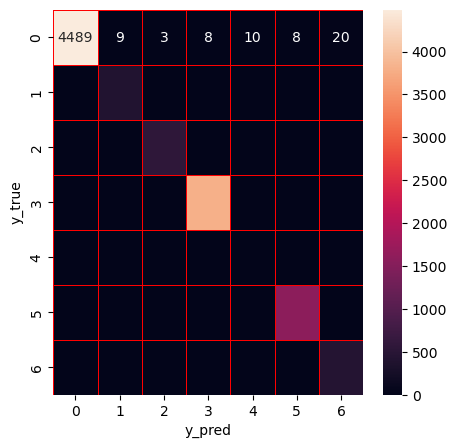

In [54]:
dt_hpo = DecisionTreeClassifier(min_samples_leaf = 2, max_depth = 49, min_samples_split = 3, max_features = 11, criterion = 'entropy')
dt_hpo.fit(X_train,y_train)
dt_score=dt_hpo.score(X_test,y_test)
y_predict=dt_hpo.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [55]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

### Stacking

In [57]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,XgBoost
0,5,5,5
1,3,3,3
2,5,5,5
3,3,3,3
4,2,2,2


In [58]:
dt_train=dt_train.reshape(-1, 1)

rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)

dt_test=dt_test.reshape(-1, 1)

rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [59]:
x_train = np.concatenate(( dt_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9932939204094238
Precision of Stacking: 0.9937243031789555
Recall of Stacking: 0.9932939204094238
F1-score of Stacking: 0.99344603297456
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.98      0.99      0.98       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.38      0.71      0.50         7
           5       1.00      1.00      1.00      1589
           6       0.95      0.99      0.97       436

    accuracy                           0.99     11333
   macro avg       0.90      0.95      0.92     11333
weighted avg       0.99      0.99      0.99     11333



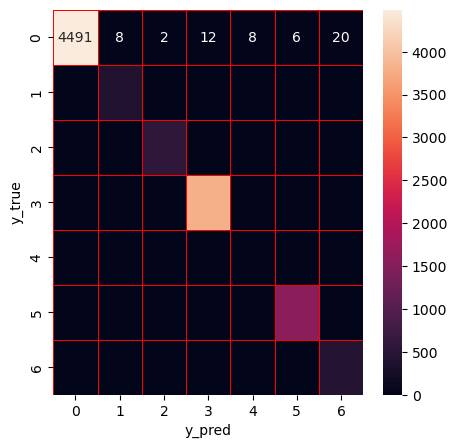

In [60]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [61]:
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [01:38<00:00,  4.94s/trial, best loss: -0.9934703961881232]
XGBoost: Hyperopt estimated optimum {'learning_rate': 0.9300780849510109, 'max_depth': 98.0, 'n_estimators': 25.0}


Accuracy of XGBoost: 0.9934703961881232
Precision of XGBoost: 0.994592125371761
Recall of XGBoost: 0.9934703961881232
F1-score of XGBoost: 0.9939205349813756
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.99      0.99      0.99       393
           2       0.99      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.23      0.71      0.34         7
           5       1.00      1.00      1.00      1589
           6       0.95      0.99      0.97       436

    accuracy                           0.99     11333
   macro avg       0.88      0.95      0.90     11333
weighted avg       0.99      0.99      0.99     11333



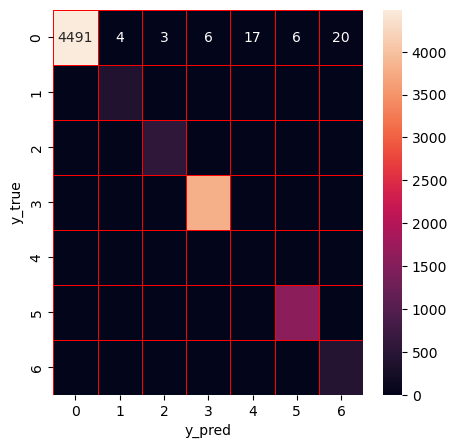

In [62]:
xg = xgb.XGBClassifier(learning_rate= 0.9300780849510109, n_estimators = 25, max_depth = 98)
xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Anomaly based IDS